In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

<h1>Tabulating ribosome densities for each dataset</h1>

In [2]:
#read in list of datasets to be processed and context information (length) for genes
Datasets = pd.read_csv('Data/yeast_datasets.csv')
genes = pd.read_csv('Data/sacCer3 genes.csv')[['name','length']]; genes.columns = ['ORF','length']
#prepare a dataframe to receive the results
densities = pd.DataFrame({'ORF':genes['ORF']})
#process each dataset file listed in the Datasets table
for Dataset in Datasets['SeriesID']:
    #read in dataset
    dats = pd.read_csv("Data/" + Dataset + '.csv')
    #add reference RNA data if RNA data not included in dataset
    if 'RNA_Prints' not in dats.columns:
        RNA_dats = pd.read_csv('Data/RNA_reference.csv')
        dats=dats.merge(RNA_dats, how='inner',on='ORF')
    #remove all datapoints where RNA = 0 to avoid dividing by zero
    dats = dats.loc[dats['RNA_Prints'] > 0]
    #add information on gene lengths to enable calculation of RPK values
    dats = dats.merge(genes, how='inner',on='ORF')
    #calculate conversion factors from RNA RPK / Ribo Prints numbers of RNAs / Ribosomes
    RNA_Conv = 60000 / (dats['RNA_Prints']/dats['length']/1000).sum()
    Ribo_Conv = 170000 / dats['Ribo_Prints'].sum()
    #calculate ribosome densities
    dats[Dataset] = (dats['Ribo_Prints'] * Ribo_Conv) / ((dats['RNA_Prints'] / dats['length']/1000)*RNA_Conv)
    #discard unnecessary columns
    dats = dats[['ORF',Dataset]]
    #merge data for this dataset into the main table
    densities = densities.merge(dats, how='left',on='ORF')
    densities = densities.fillna(0)

<h2>Comparing average ribosome densities across clusters</h2>

In [3]:
by_cluster = pd.DataFrame({'ORF':genes['ORF']})
for cluster in Datasets['cluster'].unique():
    this_set = Datasets.loc[Datasets['cluster'] == cluster]
    cols = list(this_set['SeriesID'])
    cols.append('ORF')
    these_densities = densities[cols]
    these_densities[cluster] = these_densities.mean(axis=1)
    these_densities = these_densities[['ORF',cluster]]
    by_cluster = by_cluster.merge(these_densities, how = 'left', on='ORF')

<ipython-input-3-d538d66b81ac>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  these_densities[cluster] = these_densities.mean(axis=1)
<ipython-input-3-d538d66b81ac>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  these_densities[cluster] = these_densities.mean(axis=1)
<ipython-input-3-d538d66b81ac>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

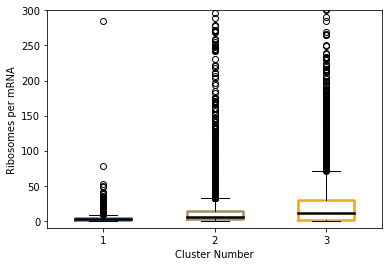

In [4]:
medianprops = dict(linewidth=2.5, color='black')
boxwidth = (0.5,)
fig,ax = plt.subplots()
ax.boxplot(by_cluster[1].values,positions = (1,),widths=boxwidth,boxprops={'color':'#4682b4','linewidth':2.5},medianprops = medianprops)
ax.boxplot(by_cluster[2].values,positions = (2,),widths=boxwidth,boxprops={'color':'#9f935e','linewidth':2.5},medianprops = medianprops)
ax.boxplot(by_cluster[3].values,positions = (3,),widths=boxwidth,boxprops={'color':'#ffa500','linewidth':2.5},medianprops = medianprops)
ax.set_ylim((-10,300))
ax.set_ylabel('Ribosomes per mRNA')
ax.set_xlabel('Cluster Number')
#plt.savefig('Supp Figure 2.svg')
plt.show()

<h2>mRNAs exceeding physically possible Ribosome loads</h2>
<p>Based on the published physical dimension of a translating ribosome of 30 nt, the maximum ribosome capacity of an mRNA can be calcualted from its length. This analysis asks how many mRNAs exceed this physically possible limit in each dataset.</p>

In [5]:
mRNA_dats = pd.read_csv('Data/sacCer3 genes.csv')[['name','length']]
by_cluster = by_cluster.merge(mRNA_dats,how='inner',left_on='ORF',right_on='name')

In [6]:
percentage_max = by_cluster[['ORF',3,1,2]]
for col in [1,2,3]:
    for row in range(by_cluster.shape[0]):
        percentage_max.iloc[row,col] = by_cluster.iloc[row,col] / (by_cluster.loc[row, 'length']/30)

C:\Users\Tvon-\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


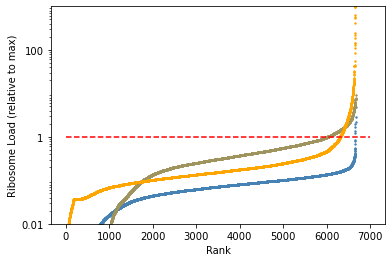

In [7]:
fig,ax = plt.subplots()
colors = ['#4682b4','#9f935e','#ffa500']
for cluster in [1,2,3]:
    this_cluster = percentage_max.loc[:,cluster]
    this_cluster= sorted(this_cluster)
    this_cluster = this_cluster[:-2]
    x = range(len(this_cluster))
    color_vec = []
    this_color = colors[cluster-1]
    ax.scatter(x,this_cluster,s=2,c=this_color)
ax.plot((0,7000),(1,1),linestyle='--',color='red')
ax.set_yscale('log')
ax.set_ylim((0.01,1000))
ax.set_xlabel('Rank')
ax.set_ylabel('Ribosome Load (relative to max)')
ax.set_yticks([0.01,1,100])
ax.set_yticklabels([0.01,1,100])
#plt.savefig('Rel_load.svg')
plt.show()